In [10]:
import os

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path_I = os.path.abspath(os.path.join(path, 'train_dataset_method_I_balanced'))
GUT_test_path_I = os.path.join(path, 'GUT_test_method_I_balanced').replace("\\", "/")
ITU_YU_test_path_I = os.path.join(path, 'ITU_YU_test_method_I_balanced').replace("\\", "/")
MAAP_test_path_I = os.path.join(path, 'MAAP_test_method_I_balanced').replace("\\", "/")

train_dataset_path_II = os.path.abspath(os.path.join(path, 'train_dataset_method_II_balanced'))
GUT_test_path_II = os.path.join(path, 'GUT_test_method_II_balanced').replace("\\", "/")
ITU_YU_test_path_II = os.path.join(path, 'ITU_YU_test_method_II_balanced').replace("\\", "/")
MAAP_test_path_II = os.path.join(path, 'MAAP_test_method_II_balanced').replace("\\", "/")

# Load datasets
train_I = tf.data.Dataset.load(train_dataset_path_I)
GUT_test_I = tf.data.Dataset.load(GUT_test_path_I)
ITU_YU_test_I = tf.data.Dataset.load(ITU_YU_test_path_I)
MAAP_test_I = tf.data.Dataset.load(MAAP_test_path_I)

train_II = tf.data.Dataset.load(train_dataset_path_II)
GUT_test_II = tf.data.Dataset.load(GUT_test_path_II)
ITU_YU_test_II = tf.data.Dataset.load(ITU_YU_test_path_II)
MAAP_test_II = tf.data.Dataset.load(MAAP_test_path_II)

full_test_I = GUT_test_I.concatenate(ITU_YU_test_I).concatenate(MAAP_test_I)
full_test_II = GUT_test_II.concatenate(ITU_YU_test_II).concatenate(MAAP_test_II)

In [12]:
emotions = ['Happy', 'Sad', 'Scared', 'Disgusted', 'Surprised', 'Angry']

## MODEL I

In [13]:
def masked_categorical_crossentropy(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [14]:
model_method_I = tf.keras.models.load_model('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_I/model.keras', custom_objects={ 'masked_categorical_crossentropy': masked_categorical_crossentropy})

In [15]:
import keras

# Save and display the model architecture
keras.utils.plot_model(model_method_I, rankdir='TB', show_shapes=True, show_layer_names=True, show_layer_activations=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
model_method_I.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 128)        │       296,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [52]:
test_set = full_test_I
# Getting predictions (chat)
y_pred = model_method_I.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


In [18]:
y_true_flat = tf.reshape(y_true, [-1, 6]).numpy()  # Shape: (112*20, 6)
y_pred_flat = y_pred.reshape(-1, 6)  # Shape: (112*20, 6)
valid_indices = np.where(np.sum(y_true_flat, axis=-1) > 0)  # Find indices where y_true is not Neutral

# Apply the valid indices to both y_pred_labels and y_true_labels
y_pred_valid = y_pred_flat[valid_indices]
y_true_valid = y_true_flat[valid_indices]  

In [19]:
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
categorical_accuracy.update_state(y_true_valid, y_pred_valid)
print(f"Categorical Accuracy: {categorical_accuracy.result().numpy()}")

Categorical Accuracy: 0.8356643319129944


In [20]:
y_true_indices = np.argmax(y_true.numpy(), axis=-1).flatten()
y_pred_indices = np.argmax(y_pred, axis=-1).flatten()

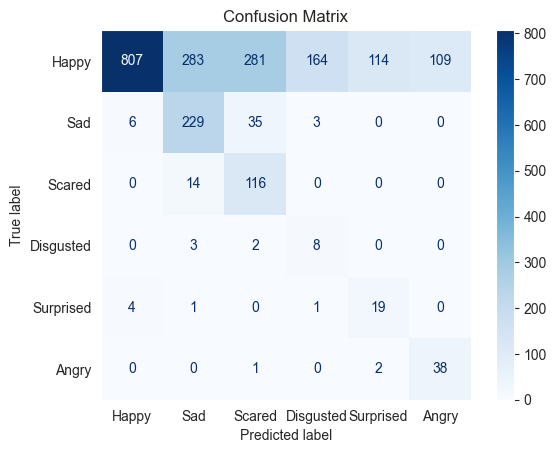

In [21]:
cm = confusion_matrix(y_true_indices, y_pred_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues', values_format='')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

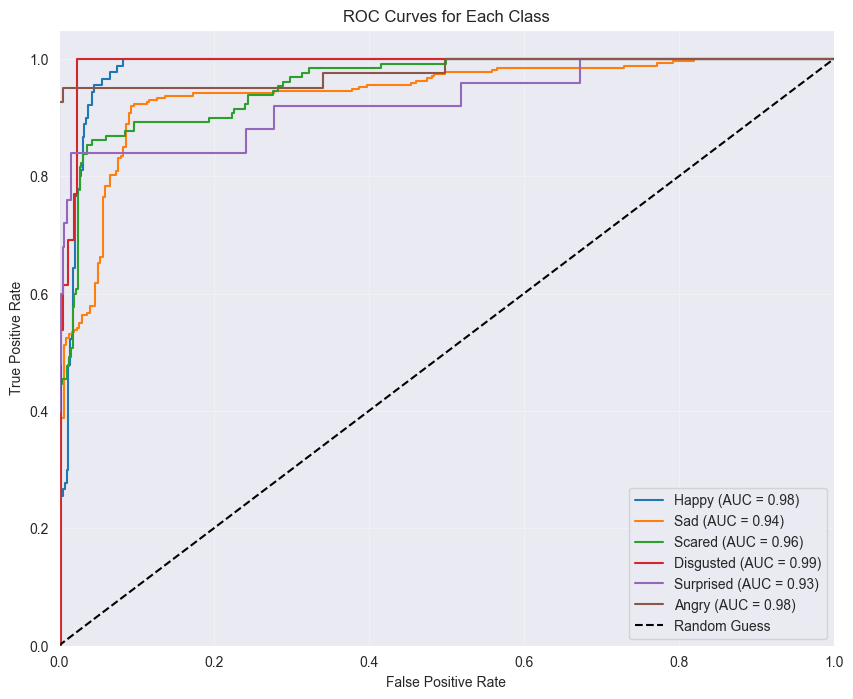

In [22]:
from sklearn.metrics import roc_curve, auc
# Initialize plot
plt.figure(figsize=(10, 8))
# Iterate over each class to calculate and plot ROC curve
for i, emotion in enumerate(emotions):
    # Get true binary labels and predicted scores for this class
    y_true_binary = y_true_valid[:, i]
    y_pred_binary_scores = y_pred_valid[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [29]:
def get_valid_indices(test_set):
    y_pred = model_method_I.predict(test_set.map(lambda x, _: x))
    y_true = tf.concat([y for _, y in test_set], axis=0)

    # Convert predictions to the most likely emotion (class with max probability)
    y_pred_labels = np.argmax(y_pred, axis=-1)  # Shape: (num_samples,)
    y_true_labels = np.argmax(y_true, axis=-1)  # Shape: (num_samples,)

    # Filter out Neutral labels (where y_true is [0, 0, 0, 0, 0, 0])
    valid_indices = np.where(np.sum(y_true, axis=-1) > 0)  # Find indices where y_true is not Neutral

    # Apply the valid indices to both y_pred_labels and y_true_labels
    y_pred_valid = y_pred_labels[valid_indices]
    y_true_valid = y_true_labels[valid_indices]

    return y_true_valid, y_pred_valid

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step


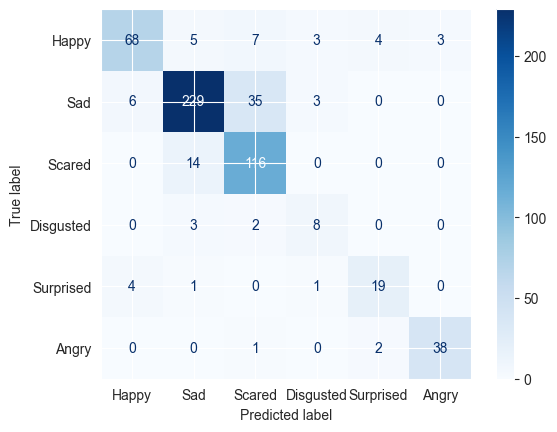

In [30]:
y_true, y_pred = get_valid_indices(test_set)

# Compute confusion matrix using valid labels
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot(cmap='Blues')


In [31]:
from sklearn.metrics import roc_curve, auc

for i, emotion in enumerate(emotions):
    # Get true binary labels and predicted scores for this emotion
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{emotion} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Emotions')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ValueError: multiclass format is not supported

In [70]:
def calculate_emotion_metrics(y_true, y_pred, emotions):
    metrics = []

    # Total number of samples
    total_samples = len(y_true)

    # Initialize totals for Micro-average
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    total_true_negatives = 0

    for i, emotion in enumerate(emotions):
        # Compute metrics for each emotion
        true_class = (y_true == i)
        pred_class = (y_pred == i)

        true_positives = np.sum(true_class & pred_class)
        false_positives = np.sum(~true_class & pred_class)
        false_negatives = np.sum(true_class & ~pred_class)
        true_negatives = total_samples - (true_positives + false_positives + false_negatives)

        # Calculate accuracy
        accuracy = (true_positives + true_negatives) / total_samples

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Append metrics for this emotion
        metrics.append({
            'Emotion': emotion,
            'True Positive': true_positives,
            'True Negative': true_negatives,
            'False Positive': false_positives,
            'False Negative': false_negatives,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Accuracy': accuracy
        })

        # Accumulate totals for micro-average
        total_true_positives += true_positives
        total_false_positives += false_positives
        total_false_negatives += false_negatives
        total_true_negatives += true_negatives

    # Calculate micro-average
    micro_precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    micro_recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    micro_accuracy = (total_true_positives + total_true_negatives) / total_samples

    # Add micro-average metrics to the list
    metrics.append({
        'Emotion': 'Micro-average',
        'True Positive': total_true_positives,
        'True Negative': total_true_negatives,
        'False Positive': total_false_positives,
        'False Negative': total_false_negatives,
        'Precision': micro_precision,
        'Recall': micro_recall,
        'F1-Score': micro_f1,
        'Accuracy': micro_accuracy
    })

    # Calculate macro-average
    macro_precision = np.mean([m['Precision'] for m in metrics[:-1]])  # Exclude micro-average
    macro_recall = np.mean([m['Recall'] for m in metrics[:-1]])       # Exclude micro-average
    macro_f1 = np.mean([m['F1-Score'] for m in metrics[:-1]])         # Exclude micro-average
    macro_accuracy = np.mean([m['Accuracy'] for m in metrics[:-1]])   # Exclude micro-average

    # Calculate total counts for the macro-average
    total_true_positives_macro = sum(m['True Positive'] for m in metrics[:-2])  # Exclude micro and macro averages
    total_false_positives_macro = sum(m['False Positive'] for m in metrics[:-2])  # Exclude micro and macro averages
    total_false_negatives_macro = sum(m['False Negative'] for m in metrics[:-2])  # Exclude micro and macro averages
    total_true_negatives_macro = sum(m['True Negative'] for m in metrics[:-2])  # Exclude micro and macro averages

    # Add macro-average metrics to the list
    metrics.append({
        'Emotion': 'Macro-average',
        'True Positive': total_true_positives_macro,
        'True Negative': total_true_negatives_macro,
        'False Positive': total_false_positives_macro,
        'False Negative': total_false_negatives_macro,
        'Precision': macro_precision,
        'Recall': macro_recall,
        'F1-Score': macro_f1,
        'Accuracy': macro_accuracy
    })

    # Convert metrics to DataFrame
    df = pd.DataFrame(metrics)
    return df

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_emotion_metrics(df, output_path="Plots/Emotion_Metrics.png", institution='Total'):
    # Exclude 'Micro-average' and 'Macro-average'
    emotions = df['Emotion'][:-2].tolist()

    # Prepare data
    metrics = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    metric_percentages = []

    for metric in metrics:
        percentages = []
        for emotion in emotions:
            # Get the value for this metric and emotion
            value = df.loc[df['Emotion'] == emotion, metric].values[0]

            # Calculate total instances for this emotion
            total_instances = (
                    df.loc[df['Emotion'] == emotion, 'True Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'True Negative'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Negative'].values[0]
            )

            # Calculate percentage
            percentages.append((value / total_instances) * 100)

        metric_percentages.append(percentages)

    # Create the plot
    plt.figure(figsize=(12, 6), dpi=150)

    # Set width of bars
    bar_width = 0.2

    # Set positions of bars on X axis
    r1 = np.arange(len(emotions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Create bars
    plt.bar(r1, metric_percentages[0], color='green', width=bar_width, label='True Positive')
    plt.bar(r2, metric_percentages[1], color='blue', width=bar_width, label='True Negative')
    plt.bar(r3, metric_percentages[2], color='red', width=bar_width, label='False Positive')
    plt.bar(r4, metric_percentages[3], color='orange', width=bar_width, label='False Negative')

    # Add labels and title
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Percentage of Total (%)', fontsize=12)
    plt.title(f'Emotion Metrics Distribution for {institution}', fontsize=14)

    # Add xticks on the middle of the group bars
    plt.xticks([r + bar_width*1.5 for r in range(len(emotions))], emotions, rotation=45, ha='right')

    # Create legend
    plt.legend()

    # Set y-axis to go from 0 to 100
    plt.ylim(0, 100)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(output_path, dpi=1200)
    plt.show()

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def plot_emotion_metrics_heatmap(df, output_path="Plots/Emotion_Metrics_Heatmap.png", institution='Total'):
    # Exclude 'Micro-average' and 'Macro-average'
    emotions = df['Emotion'][:-2].tolist()

    # Prepare data: Extract metrics and organize them into a DataFrame
    metrics = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
    metric_percentages = []

    for metric in metrics:
        percentages = []
        for emotion in emotions:
            # Get the value for this metric and emotion
            value = df.loc[df['Emotion'] == emotion, metric].values[0]

            # Calculate total instances for this emotion
            total_instances = (
                    df.loc[df['Emotion'] == emotion, 'True Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'True Negative'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Positive'].values[0] +
                    df.loc[df['Emotion'] == emotion, 'False Negative'].values[0]
            )

            # Calculate percentage
            percentages.append((value / total_instances) * 100)

        metric_percentages.append(percentages)

    # Convert the list to a DataFrame for better manipulation
    heatmap_data = pd.DataFrame(metric_percentages, index=metrics, columns=emotions)

    # Create the heatmap plot
    plt.figure(figsize=(12, 6), dpi=150)

    # Use seaborn to plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Percentage of Total (%)'}, fmt=".2f",
                linewidths=0.5, linecolor='gray')

    # Add labels and title
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Metrics', fontsize=12)
    plt.title(f'Emotion Metrics Distribution for {institution}', fontsize=14)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(output_path, dpi=1200)
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step


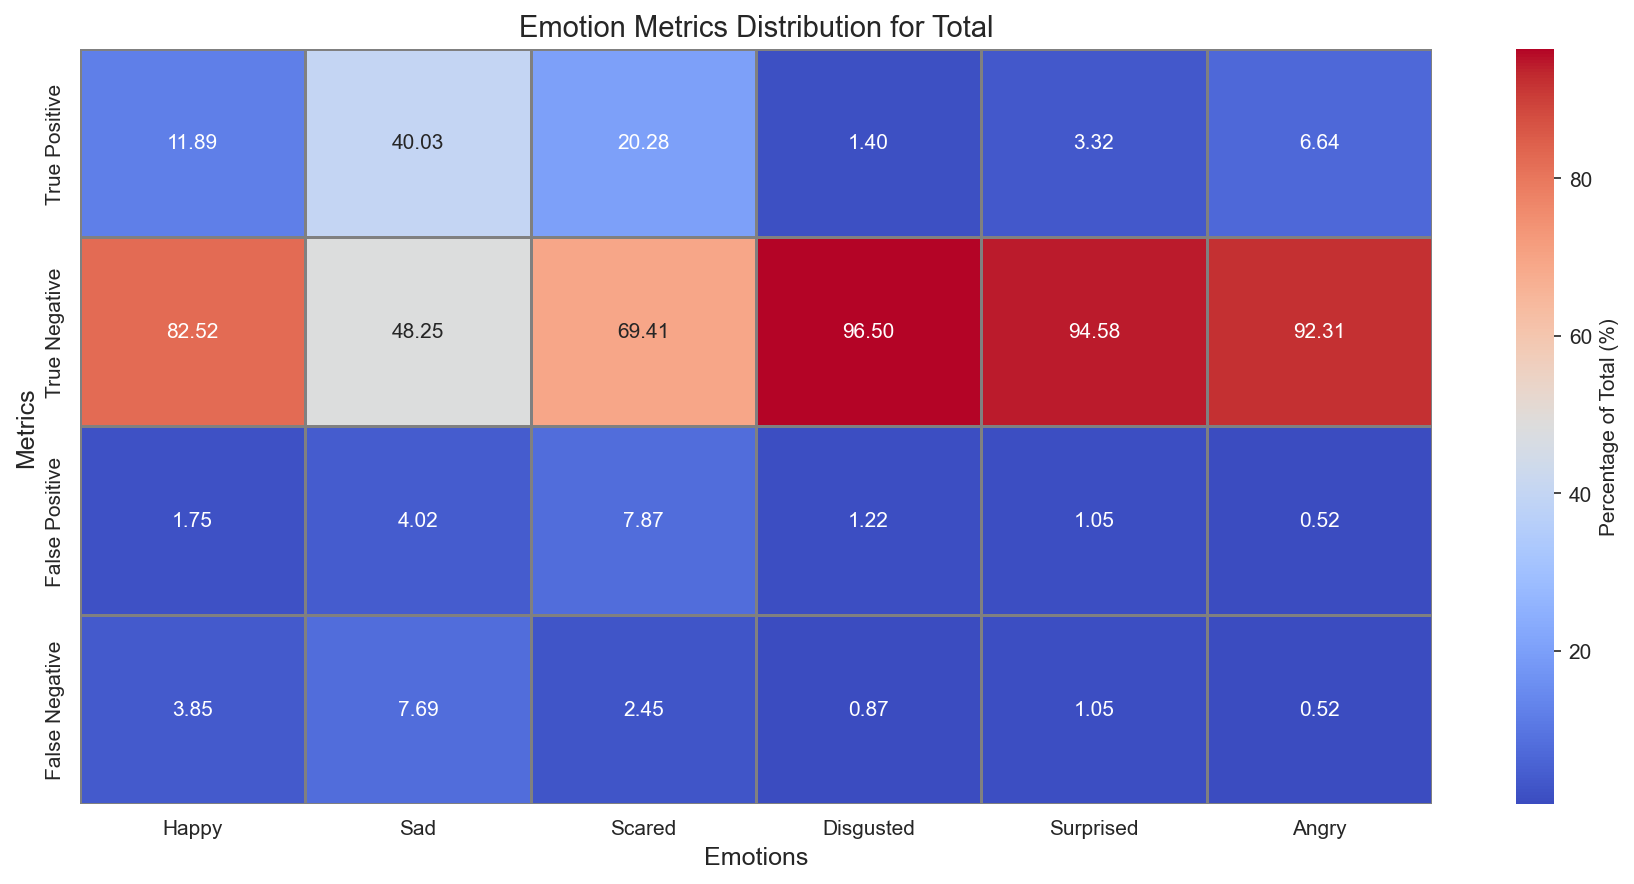

In [102]:
y_true, y_pred = get_valid_indices(full_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
plot_emotion_metrics_heatmap(metrics, output_path="Plots/Method_I_Heatmap_Full.png", institution='Total')

In [71]:
y_true, y_pred = get_valid_indices(full_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
plot_emotion_metrics(metrics, output_path="Plots/Emotion_MetricsTotal.png", institution='Total')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step


In [82]:
def export_metrics_to_latex(metrics_df, output_file='emotion_metrics.tex'):
    """
    Export emotion metrics to a LaTeX table
    
    Args:
        metrics_df (pd.DataFrame): DataFrame with emotion metrics
        output_file (str): Path to save the LaTeX table
    """
    # Select relevant columns
    display_columns = ['Emotion', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Prepare the table
    latex_table = metrics_df[display_columns].copy()

    # Round numeric columns to 4 decimal places
    numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    for col in numeric_cols:
        latex_table[col] = latex_table[col].apply(lambda x: f'{x:.4f}')

    # Convert to LaTeX
    latex_output = latex_table.to_latex(
        index=False,
        float_format='{:.4f}'.format,
        column_format='l' + 'c' * (len(display_columns) - 1)
    )

    # Write to file
    with open(output_file, 'w') as f:
        f.write(latex_output)

    return latex_output

In [86]:
y_true, y_pred = get_valid_indices(GUT_test_I)
metrics = calculate_emotion_metrics(y_true, y_pred, emotions)
export_metrics_to_latex(metrics, output_file="LatexTables/MetricsGUT.tex")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


'\\begin{tabular}{lcccc}\n\\toprule\nEmotion & Accuracy & Precision & Recall & F1-Score \\\\\n\\midrule\nHappy & 1.0000 & 1.0000 & 1.0000 & 1.0000 \\\\\nSad & 0.7500 & 0.7273 & 1.0000 & 0.8421 \\\\\nScared & 1.0000 & 0.0000 & 0.0000 & 0.0000 \\\\\nDisgusted & 0.7500 & 0.0000 & 0.0000 & 0.0000 \\\\\nSurprised & 1.0000 & 0.0000 & 0.0000 & 0.0000 \\\\\nAngry & 1.0000 & 0.0000 & 0.0000 & 0.0000 \\\\\nMicro-average & 5.5000 & 0.7500 & 0.7500 & 0.7500 \\\\\nMacro-average & 0.9167 & 0.2879 & 0.3333 & 0.3070 \\\\\n\\bottomrule\n\\end{tabular}\n'

## MODEL II

In [4]:
def masked_mean_squared_error(y_true, y_pred):
    """
    y_true: true labels, one-hot encoded. Shape (batch_size, sequence_length, OUTPUT_DIM)
    y_pred: predicted probabilities. Shape (batch_size, sequence_length, OUTPUT_DIM)
    """
    # Create a mask: 1 for valid labels (non-[0, 0, 0]), 0 for "Unknown" ([0, 0, 0])
    mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, sequence_length)
    mask = tf.cast(mask, tf.float32)  # Convert boolean mask to float32 for multiplication
    
    # Compute categorical cross-entropy loss
    loss = tf.square(y_true - y_pred)
    
    # Apply the mask to the loss
    loss = loss * mask[..., tf.newaxis]  # Zero out loss for "Unknown" labels
    
    # Return mean loss over valid labels
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [5]:
model_method_II = tf.keras.models.load_model(
    '//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Models/model_method_II/model.keras', custom_objects={"masked_mean_squared_error": masked_mean_squared_error})

In [6]:
model_method_II.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 20, 128)        │       296,960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 20, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,484 (3.52 MB)

 Trainable params: 307,494 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 614,990 (2.35 MB)

In [8]:
test_set = full_test_II
# Getting predictions (chat)
y_pred = model_method_II.predict(test_set.map(lambda x, _: x))
y_true = tf.concat([y for _, y in test_set], axis=0)
# Helper function to compute metrics for a single emotion
def compute_all_metrics(y_true, y_pred):
    """
    Compute MAS, MSE, MAE, RMSE, and R² for masked values of y_true and y_pred.
    
    Args:
        y_true (tf.Tensor): Ground truth values after masking.
        y_pred (tf.Tensor): Predicted values after masking.
    
    Returns:
        dict: A dictionary with computed metrics.
    """
    def compute_mse(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)).numpy()

    def compute_mae(y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true - y_pred)).numpy()

    def compute_rmse(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return tf.sqrt(mse).numpy()

    def compute_r2(y_true, y_pred):
        total_variance = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        residual_variance = tf.reduce_sum(tf.square(y_true - y_pred))
        return (1 - residual_variance / total_variance).numpy()

    def compute_similarity(y_true, y_pred):
        similarity = 1 - tf.abs(y_true - y_pred)
        mas = tf.reduce_mean(similarity).numpy()
        label_count = tf.size(y_true).numpy()
        return mas, label_count

    # Compute metrics
    mse = compute_mse(y_true, y_pred)
    mae = compute_mae(y_true, y_pred)
    rmse = compute_rmse(y_true, y_pred)
    r2 = compute_r2(y_true, y_pred)
    mas, label_count = compute_similarity(y_true, y_pred)

    return {
        'Labels Used': label_count,
        'MAS': mas,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

# Main loop to compute metrics for all emotions
def compute_metrics_for_all_emotions(y_true, y_pred, emotions):
    """
    Compute all metrics for each emotion.
    
    Args:
        y_true (tf.Tensor): Ground truth values (shape: [batch_size, sequence_length, num_emotions]).
        y_pred (tf.Tensor): Predicted values (shape: [batch_size, sequence_length, num_emotions]).
        emotions (list): List of emotion names.
    
    Returns:
        list: A list of dictionaries containing metrics for each emotion.
    """
    metric_results = []

    for i, emotion in enumerate(emotions):
        # Extract true and predicted values for the specific emotion
        true_values = tf.cast(y_true[:, :, i], tf.float32)
        pred_values = tf.cast(y_pred[:, :, i], tf.float32)
        
        # Mask non-zero true values
        mask = tf.not_equal(true_values, 0)
        true_values_masked = tf.boolean_mask(true_values, mask)
        pred_values_masked = tf.boolean_mask(pred_values, mask)
        
        # Compute all metrics using the helper function
        metrics = compute_all_metrics(true_values_masked, pred_values_masked)
        metrics['emotion'] = emotion  # Add emotion name to the result
        
        # Append to results
        metric_results.append(metrics)

        # Print for immediate feedback
        print(f"Emotion: {emotion}, Metrics: {metrics}")

    return metric_results

# Example Usage
# Assuming `emotions` is a list of emotion names, and `y_true` and `y_pred` are already defined
results = compute_metrics_for_all_emotions(y_true, y_pred, emotions)

# Results are already printed inside the loop


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step
Emotion: Happy, Metrics: {'Labels Used': 1733, 'MAS': 0.7714122, 'MSE': 0.092365295, 'MAE': 0.22858784, 'RMSE': 0.3039166, 'R²': -0.5547128, 'emotion': 'Happy'}
Emotion: Sad, Metrics: {'Labels Used': 1020, 'MAS': 0.82074165, 'MSE': 0.056170255, 'MAE': 0.17925833, 'RMSE': 0.23700264, 'R²': -1.7504737, 'emotion': 'Sad'}
Emotion: Angry, Metrics: {'Labels Used': 764, 'MAS': 0.84800553, 'MSE': 0.042449046, 'MAE': 0.15199442, 'RMSE': 0.20603167, 'R²': 0.14819503, 'emotion': 'Angry'}
Emotion: Fear, Metrics: {'Labels Used': 426, 'MAS': 0.7566955, 'MSE': 0.06877991, 'MAE': 0.2433045, 'RMSE': 0.26225924, 'R²': -18.03748, 'emotion': 'Fear'}
Emotion: Disgusted, Metrics: {'Labels Used': 286, 'MAS': 0.803003, 'MSE': 0.05415352, 'MAE': 0.19699703, 'RMSE': 0.2327091, 'R²': -5.1655345, 'emotion': 'Disgusted'}
Emotion: Surprised, Metrics: {'Labels Used': 409, 'MAS': 0.7801965, 'MSE': 0.06328549, 'MAE': 0.21980351, 'RMSE': 0.25156608, 'R²': -5.600141, 'emotion': '